# Toy compartmental model for COVID19 in Australia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Context/Outline" data-toc-modified-id="Context/Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Context/Outline</a></span></li><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python set up</a></span></li><li><span><a href="#Assumptions---model/set-up" data-toc-modified-id="Assumptions---model/set-up-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Assumptions - model/set-up</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The model</a></span><ul class="toc-item"><li><span><a href="#The-ODE-model" data-toc-modified-id="The-ODE-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The ODE model</a></span></li><li><span><a href="#Starting-points" data-toc-modified-id="Starting-points-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Starting points</a></span></li><li><span><a href="#Use-an-ODE-solver" data-toc-modified-id="Use-an-ODE-solver-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Use an ODE solver</a></span></li><li><span><a href="#Plot-and-describe" data-toc-modified-id="Plot-and-describe-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Plot and describe</a></span></li><li><span><a href="#plot-comparative" data-toc-modified-id="plot-comparative-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>plot comparative</a></span></li><li><span><a href="#Run-the-model" data-toc-modified-id="Run-the-model-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run the model</a></span></li></ul></li></ul></div>

## Context/Outline

This implements a simple SEIRV model, where the population is compartmentalised into five mutually exclusive compartments: 

Model States:
*   S - susceptible population
*   E - exposed population
*   I - infectious unquarantined population
*   R - recovered/DEAD population
*   V - vaccinated population (that never had COVID)

Model factors:
*   $\alpha$ - 1/exposure period
*   $\beta$ - r0/infectious period
*   $\gamma$ - 1/infectious period
*   $\delta$ - proportion of the population vaccinated every day

Ordinary differential equations
$$\begin{align}
\frac{dS}{dt} & = -\beta SI - \delta t \ (where: v < cap)\\
\frac{dE}{dt} & = \beta SI - \alpha E \\
\frac{dI}{dt} & = \alpha E - \gamma I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dV}{dt} & = \delta t\ (where: v < cap) \\
\end{align} $$

Where:
$$\begin{align}
\frac{d(S+E+I+R+V)}{dt} & = 0 \\
S+E+I+R+V & = 1 \\
\end{align}$$


## Python set up

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import scipy.integrate

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting
plt.style.use('ggplot')

# where to save the plot
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!SIR-!ODE-'

## Assumptions - model/set-up

In [2]:
N_DAYS = 200                # days - model period
STEP_SIZE = .01             # fraction of days
H = int(1 / STEP_SIZE)      # steps per day
POPULATION = 8_166_000      # NSW POPULATION
e_period = 2                # exposure period - days 
                            # to the point of being infectious,
                            # so less than to the point of having
                            # symptoms
i_period = 12               # fully infectious period - days

# Other
case_fatality_rate = 0.02   # proportion of those infected
VACCINATION_MAX_OUT = 0.7   # proportion of the population that will get vaccinated

## The model

### The ODE model

In [3]:
def SEIR_model(y, t, alpha, beta, gamma, delta):
    s, e, i, r, v = y
    
    # an unusual vacination function
    vaxxedΔ = delta 
    if v + r > VACCINATION_MAX_OUT:
        vaxxedΔ = 0  
    
    ds_dt = (-beta * s * i) - vaxxedΔ
    de_dt = (beta * s * i) - (alpha * e)
    di_dt = (alpha * e) - (gamma * i)
    dr_dt = (gamma * i)
    dv_dt = vaxxedΔ
    
    return ds_dt, de_dt, di_dt, dr_dt, dv_dt

### Starting points

In [4]:
def get_parameters(r0):
    # y - starting points - ensure sum to one
    y = np.zeros(5) # S E I R V
    y[1] = 700 / POPULATION # e
    y[2] = 2300 / POPULATION # i
    y[3] = 0.0 # r
    y[4] = 0.2 # v
    y[0] = 1.0 - y[1] - y[2] - y[3] - y[4] # s

    # t - times slices
    t = np.linspace(0, N_DAYS, N_DAYS*H)

    # parameters
    beta = r0 / i_period
    alpha = 1 / e_period
    gamma = 1 / i_period
    delta = 90_000 / POPULATION # proportion of the population vaxxed every day
    print(f'alpha: {alpha}, beta: {beta}, gamma: {gamma}, delta: {delta}')

    return y, t, alpha, beta, gamma, delta

### Use an ODE solver

In [5]:
def solve(r0):
    
    y0, t, alpha, beta, gamma, delta = get_parameters(r0)

    solution = scipy.integrate.odeint(SEIR_model, y0,
        t, args=(alpha, beta, gamma, delta))
       
    # put the solution into a DataFrame
    solution = pd.DataFrame(solution, columns = ['susceptible',
            'exposed', 'infectious', 'removed', 'vaccinated'])
    solution.index = solution.index / H # return index to days

    # calculate deaths
    solution['dead'] = solution['removed'] * case_fatality_rate
    solution['recovered'] = solution['removed'] - solution['dead']
    del solution['removed']

    return solution

### Plot and describe

In [6]:
def plot_solution(solution, r0):
    ax = solution.plot(lw=2)
    t = f'COVID19: toy SEIR ODE solution, ' '$R_{eff}=' f'{r0}$'
    ax.set_title(t)
    ax.set_xlabel('Day')
    ax.set_ylabel('Population Proportion')
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY}-{t}.png', dpi=125)
    plt.show()
    plt.close()

    # key results
    print('Susceptible at end: '+
          f'{int(solution.susceptible.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.susceptible.iloc[-1]*100, 1)}%)')
    print('Resistant at end: '+
          f'{int(solution.recovered.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.recovered.iloc[-1]*100, 1)}%)')
    print('Dead at end: '+
          f'{int(solution.dead.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.dead.iloc[-1]*100, 1)}%)')

### plot comparative

In [7]:
def plot_comparative(data, title):

    data = data * POPULATION
    ax = data.plot(lw=2)
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_ylabel('the New South Welsh')
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY}-{title}.png', dpi=125)
    plt.show()
    plt.close()

### Run the model

---------------
alpha: 0.5, beta: 0.19999999999999998, gamma: 0.08333333333333333, delta: 0.011021307861866276


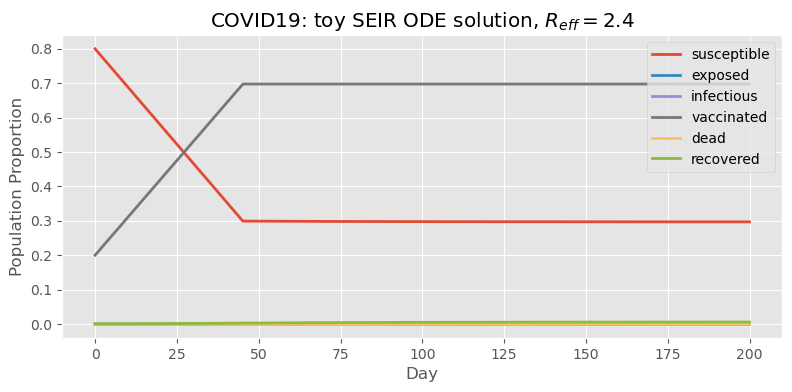

Susceptible at end: 2,423,405 (29.7%)
Resistant at end: 46,384 (0.6%)
Dead at end: 946 (0.0%)
---------------
alpha: 0.5, beta: 0.18333333333333335, gamma: 0.08333333333333333, delta: 0.011021307861866276


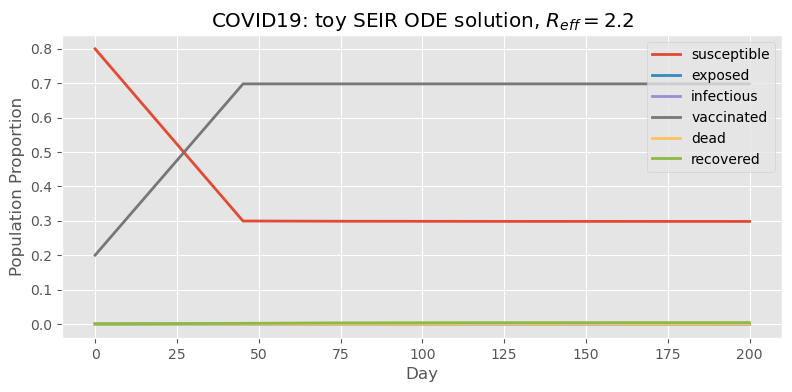

Susceptible at end: 2,433,760 (29.8%)
Resistant at end: 32,757 (0.4%)
Dead at end: 668 (0.0%)
---------------
alpha: 0.5, beta: 0.16666666666666666, gamma: 0.08333333333333333, delta: 0.011021307861866276


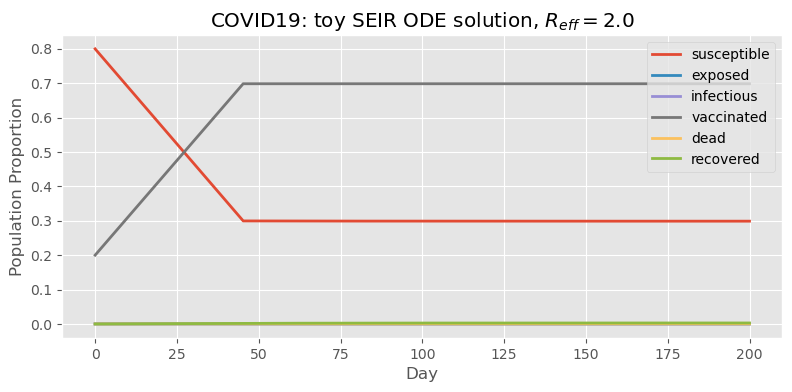

Susceptible at end: 2,439,953 (29.9%)
Resistant at end: 23,778 (0.3%)
Dead at end: 485 (0.0%)
---------------
alpha: 0.5, beta: 0.15, gamma: 0.08333333333333333, delta: 0.011021307861866276


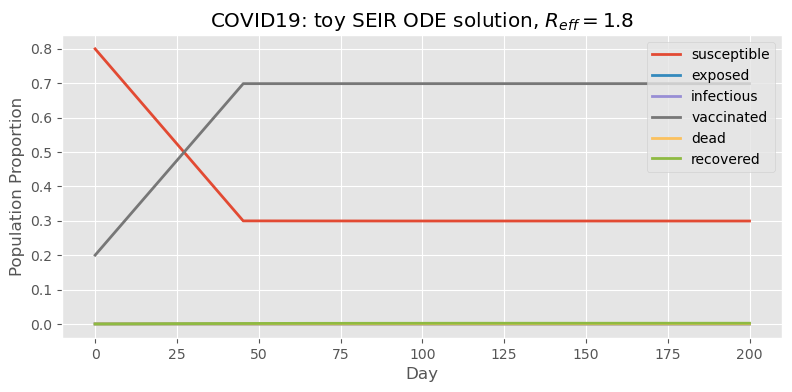

Susceptible at end: 2,443,708 (29.9%)
Resistant at end: 17,707 (0.2%)
Dead at end: 361 (0.0%)
---------------
alpha: 0.5, beta: 0.13333333333333333, gamma: 0.08333333333333333, delta: 0.011021307861866276


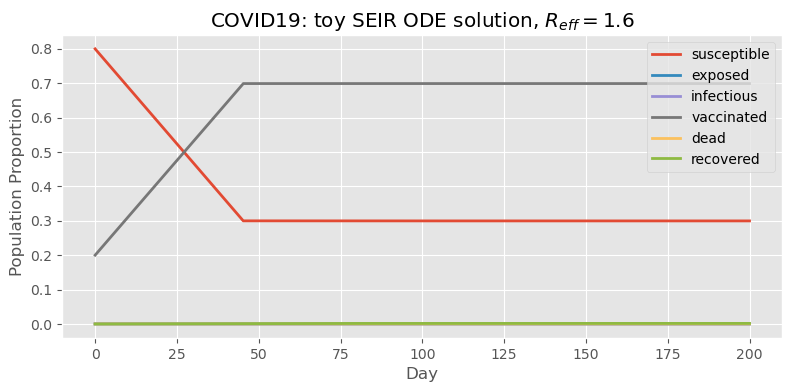

Susceptible at end: 2,446,013 (30.0%)
Resistant at end: 13,495 (0.2%)
Dead at end: 275 (0.0%)
---------------
alpha: 0.5, beta: 0.11666666666666665, gamma: 0.08333333333333333, delta: 0.011021307861866276


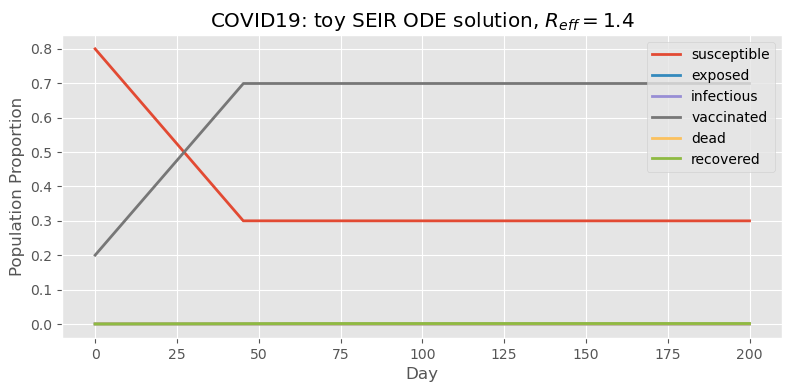

Susceptible at end: 2,447,442 (30.0%)
Resistant at end: 10,506 (0.1%)
Dead at end: 214 (0.0%)
---------------


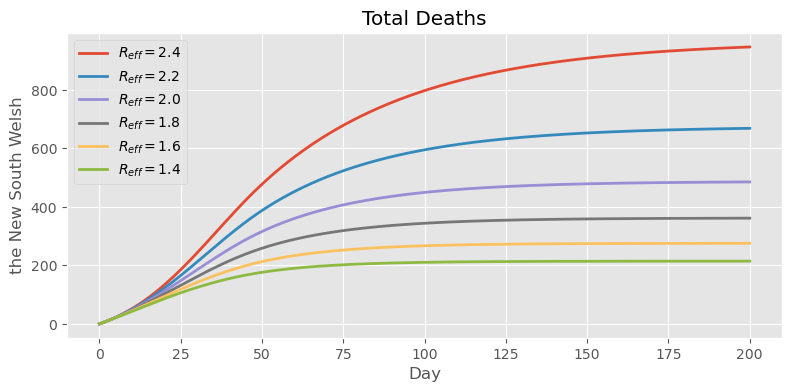

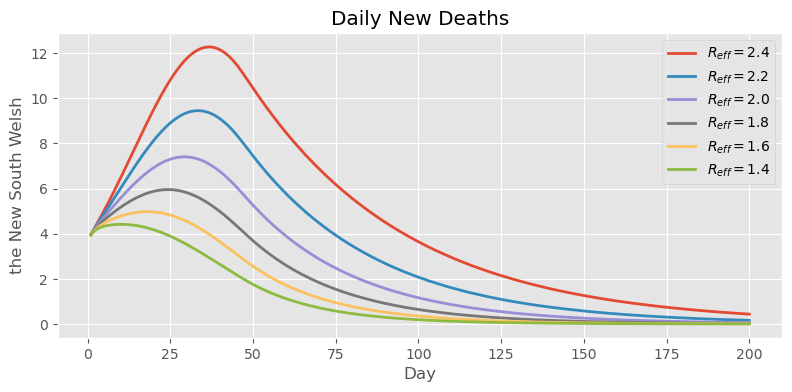

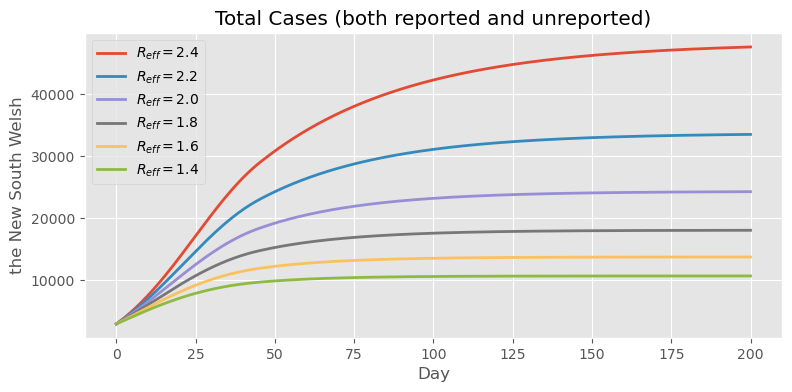

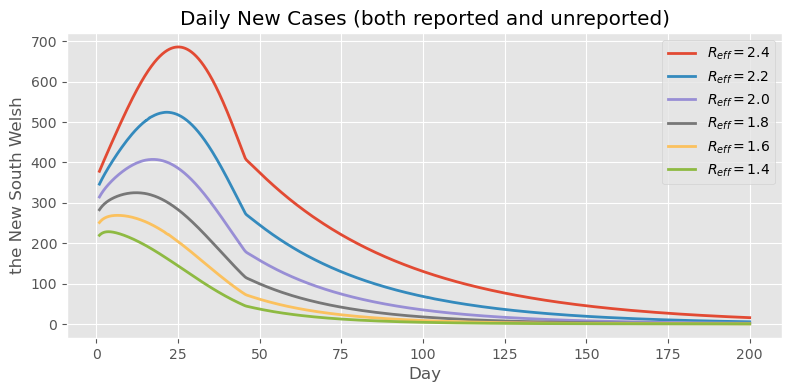

In [8]:
deaths = pd.DataFrame()
cases = pd.DataFrame()
for r_eff in [2.4, 2.2, 2.0, 1.8, 1.6, 1.4]:
    print ('---------------')
    solution = solve(r_eff)
    plot_solution(solution, r_eff)
    label = '$R_{eff}=' f'{r_eff}$'
    deaths[label] = solution['dead']
    cases[label] = (
        solution['exposed'] + solution['infectious'] + 
        solution['recovered'] + solution['dead']
    )        

print ('---------------')
plot_comparative(deaths, 'Total Deaths')
plot_comparative(deaths.diff(H), 'Daily New Deaths')
plot_comparative(cases, 'Total Cases (both reported and unreported)')
plot_comparative(cases.diff(H), 'Daily New Cases (both reported and unreported)')


The End